# **Caso: Reclamos en una Empresa de Seguros**

El objetivo es construir un modelo para poder calcular la probabilidad de que un cliente presente un reclamo de seguro. Como la proporción de clientes que cumplen con esta condición es reducida, aprovecharemos este caso para probar distintos métodos de balanceo de muestras.

https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data


In [1]:
## Podemos hacer el balanceo de manera artesanal, para entender las lógicas.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **Carga de la base de datos**

Desarrollar el mejor modelo de propensión que prediga si se logrará la venta de un préstamo digital.

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head(5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
train.target.value_counts(normalize=True)

target
0    0.963552
1    0.036448
Name: proportion, dtype: float64

In [5]:
train.target.value_counts()

target
0    573518
1     21694
Name: count, dtype: int64

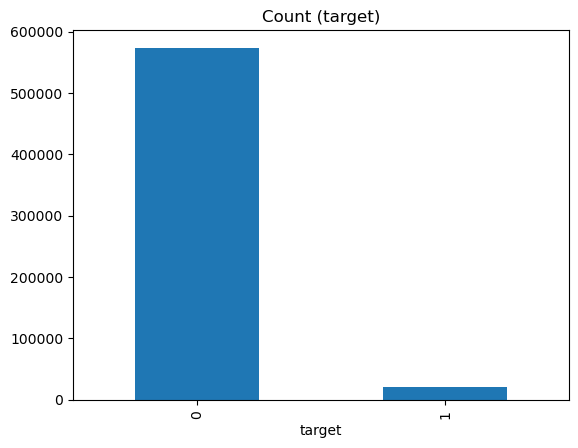

In [49]:
train.target.value_counts().plot(kind='bar', title='Count (target)');

In [9]:
train.dtypes

id                  int64
target              int64
ps_ind_01           int64
ps_ind_02_cat       int64
ps_ind_03           int64
ps_ind_04_cat       int64
ps_ind_05_cat       int64
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14           int64
ps_ind_15           int64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat       int64
ps_car_02_cat       int64
ps_car_03_cat       int64
ps_car_04_cat       int64
ps_car_05_cat       int64
ps_car_06_cat       int64
ps_car_07_cat       int64
ps_car_08_cat       int64
ps_car_09_cat       int64
ps_car_10_cat       int64
ps_car_11_cat       int64
ps_car_11           int64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

In [10]:
df = train.sample(frac=0.9, random_state=1000)
df_unseen = train.drop(df.index)
df.reset_index(inplace=True, drop=True)
df_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(df.shape))
print('Unseen Data For Predictions: ' + str(df_unseen.shape))

Data for Modeling: (535691, 59)
Unseen Data For Predictions: (59521, 59)


In [11]:
df.target.value_counts()

target
0    516201
1     19490
Name: count, dtype: int64

### Modelos con la muestra completa

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [13]:
# limpieza básica
df = df.drop(['id'], axis=1)

In [14]:
#Separación de predictoras y predicha
X = df.drop('target', axis=1)
y = df['target']

In [15]:
#Creación de muestras de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [16]:
X_train.shape, y_train.shape

((374983, 57), (374983,))

In [17]:
X_test.shape, y_test.shape

((160708, 57), (160708,))

### Modelo Decision Tree

In [18]:
tree = DecisionTreeClassifier()
tree_model = tree.fit(X_train, y_train)
Y_pred = tree_model.predict(X_test)

In [19]:
ind = pd.DataFrame(columns = ['Modelo', 'Muestra', 'Tamaño', 'Accuracy', 'Precision', 'Recall', 'F1Score'])

In [23]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'DecisionTree', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[147239   7547]
 [  5555    367]]


In [ ]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = tree_model.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = tree_model.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('com_tree.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'DecisionTree', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind.head()

Matriz confusion: Unseen
[[54520  2797]
 [ 2067   137]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328


### Modelo XGBoost

In [26]:
xgb_mod=xgb.XGBClassifier()
xgb_mod.fit(X_train, y_train)
Y_pred= xgb_mod.predict(X_test)

In [27]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'XGBoost', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[154773     13]
 [  5917      5]]


In [28]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = xgb_mod.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = xgb_mod.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('com_xgb.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'XGBoost', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind.head()

Matriz confusion: Unseen
[[57314     3]
 [ 2202     2]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811


### Modelo RandomForest

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
Y_pred=rf.predict(X_test)

In [30]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'RandomForest', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[154782      4]
 [  5920      2]]


In [31]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = rf.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = rf.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('com_rf.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'RandomForest', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind

Matriz confusion: Unseen
[[57317     0]
 [ 2204     0]]


C:\TDAPPS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811
4,RandomForest,Test,160708,0.963138,0.333333,0.000338,0.000675
5,RandomForest,Reserva,59521,0.962971,0.000000,0.000000,0.000000


## **Resampling**

In [32]:
# Conteo de clases
count_class_0, count_class_1 = df.target.value_counts()

In [33]:
print('Cantidades por fila de clase:')
print('Class_0:',count_class_0)
print('Class_1:',count_class_1)

Cantidades por fila de clase:
Class_0: 516201
Class_1: 19490


In [34]:
# Dividiendo los sets por clases
df_class_0 = df[df['target'] == 0]
df_class_1 = df[df['target'] == 1]

In [35]:
print('Dimensión por tipo de clases:')
print('dim class_0:',df_class_0.shape)
print('dim class_1:',df_class_1.shape)

Dimensión por tipo de clases:
dim class_0: (516201, 58)
dim class_1: (19490, 58)


### 1. Random under-sampling (Submuestreo aleatorio)

In [36]:
df_class_0_under = df_class_0.sample(count_class_1*4)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

In [37]:
print('Dimensión por tipo de clases generadas:')
print('dim df_class_0_under:',df_class_0_under.shape)
print('dim df_under:',df_under.shape)

Dimensión por tipo de clases generadas:
dim df_class_0_under: (77960, 58)
dim df_under: (97450, 58)


In [38]:
print('Random under-sampling:')
print(df_under.target.value_counts())

Random under-sampling:
target
0    77960
1    19490
Name: count, dtype: int64


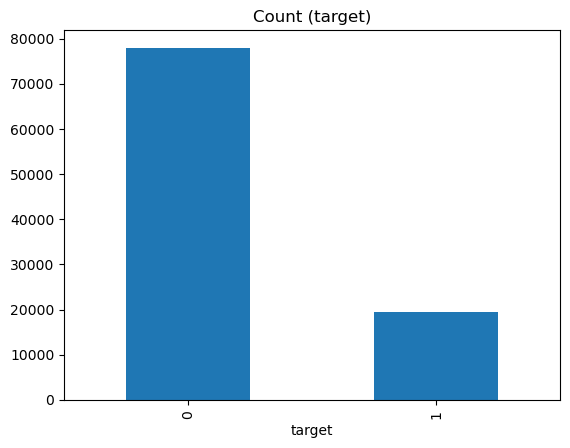

In [39]:
df_under.target.value_counts().plot(kind='bar', title='Count (target)');

In [40]:
#Separación de predictoras y predicha
X = df_under.drop('target', axis=1)
y = df_under['target']

In [41]:
#Creación de muestras de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

### Modelo Decision Tree

In [42]:
tree = DecisionTreeClassifier()
tree_model = tree.fit(X_train, y_train)
Y_pred = tree_model.predict(X_test)

In [43]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'DecisionTree Under', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[18387  4954]
 [ 4380  1514]]


In [44]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = tree_model.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = tree_model.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('under_tree.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'DecisionTree Under', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind

Matriz confusion: Unseen
[[45276 12041]
 [ 1652   552]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811
4,RandomForest,Test,160708,0.963138,0.333333,0.000338,0.000675
5,RandomForest,Reserva,59521,0.962971,0.000000,0.000000,0.000000
6,DecisionTree Under,Test,29235,0.680725,0.234075,0.256871,0.244944
7,DecisionTree Under,Reserva,59521,0.769947,0.043834,0.250454,0.074610


### Modelo XGBoost

In [45]:
xgb_mod=xgb.XGBClassifier()
xgb_mod.fit(X_train, y_train)
Y_pred= xgb_mod.predict(X_test)

In [46]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'XGBoost Under', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[22926   415]
 [ 5610   284]]


In [47]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = xgb_mod.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = xgb_mod.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('under_xgb.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'XGBoost Under', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind

Matriz confusion: Unseen
[[56265  1052]
 [ 2119    85]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811
4,RandomForest,Test,160708,0.963138,0.333333,0.000338,0.000675
5,RandomForest,Reserva,59521,0.962971,0.000000,0.000000,0.000000
6,DecisionTree Under,Test,29235,0.680725,0.234075,0.256871,0.244944
7,DecisionTree Under,Reserva,59521,0.769947,0.043834,0.250454,0.074610
8,XGBoost Under,Test,29235,0.793911,0.406295,0.048185,0.086152
9,XGBoost Under,Reserva,59521,0.946725,0.074758,0.038566,0.050883


### Modelo RandomForest

In [48]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
Y_pred=rf.predict(X_test)

In [50]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'RandomForest Under', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[23293    48]
 [ 5842    52]]


In [51]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = rf.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = rf.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('under_rf.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'RandomForest Under', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind

Matriz confusion: Unseen
[[57209   108]
 [ 2176    28]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811
4,RandomForest,Test,160708,0.963138,0.333333,0.000338,0.000675
5,RandomForest,Reserva,59521,0.962971,0.000000,0.000000,0.000000
6,DecisionTree Under,Test,29235,0.680725,0.234075,0.256871,0.244944
7,DecisionTree Under,Reserva,59521,0.769947,0.043834,0.250454,0.074610
8,XGBoost Under,Test,29235,0.793911,0.406295,0.048185,0.086152
9,XGBoost Under,Reserva,59521,0.946725,0.074758,0.038566,0.050883


### 2. Random over-sampling (Sobremuestreo aleatorio)

In [52]:
df_class_1_over = df_class_1.sample(round(count_class_0/4), replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

In [53]:
print('Dimensión por tipo de clases generadas:')
print('dim df_class_1_over:',df_class_1_over.shape)
print('dim df_over:',df_over.shape)

Dimensión por tipo de clases generadas:
dim df_class_1_over: (129050, 58)
dim df_over: (645251, 58)


In [54]:
print('Random over-sampling:')
print(df_over.target.value_counts())

Random over-sampling:
target
0    516201
1    129050
Name: count, dtype: int64


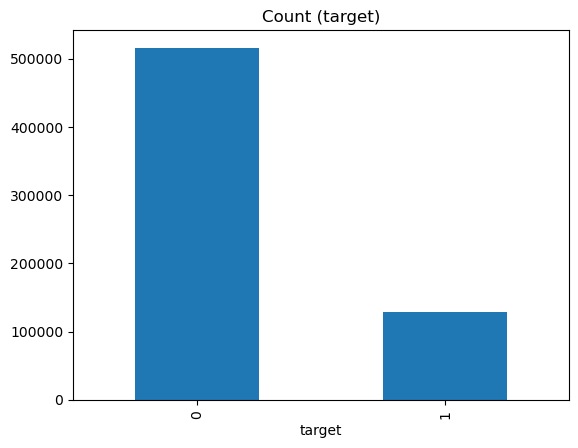

In [55]:
df_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [56]:
#Separación de predictoras y predicha
X = df_over.drop('target', axis=1)
y = df_over['target']

In [57]:
#Creación de muestras de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

### Modelo Decision Tree

In [58]:
tree = DecisionTreeClassifier()
tree_model = tree.fit(X_train, y_train)
Y_pred = tree_model.predict(X_test)

In [59]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'DecisionTree Over', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[145479   9227]
 [   358  38512]]


In [60]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = tree_model.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = tree_model.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('over_tree.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'DecisionTree Over', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind

Matriz confusion: Unseen
[[53968  3349]
 [ 2042   162]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811
4,RandomForest,Test,160708,0.963138,0.333333,0.000338,0.000675
5,RandomForest,Reserva,59521,0.962971,0.000000,0.000000,0.000000
6,DecisionTree Under,Test,29235,0.680725,0.234075,0.256871,0.244944
7,DecisionTree Under,Reserva,59521,0.769947,0.043834,0.250454,0.074610
8,XGBoost Under,Test,29235,0.793911,0.406295,0.048185,0.086152
9,XGBoost Under,Reserva,59521,0.946725,0.074758,0.038566,0.050883


### Modelo XGBoost

In [61]:
xgb_mod=xgb.XGBClassifier()
xgb_mod.fit(X_train, y_train)
Y_pred= xgb_mod.predict(X_test)

In [62]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'XGBoost Over', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[153554   1152]
 [ 34821   4049]]


In [63]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = xgb_mod.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = xgb_mod.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('over_xgb.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'XGBoost Over', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind

Matriz confusion: Unseen
[[56884   433]
 [ 2157    47]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811
4,RandomForest,Test,160708,0.963138,0.333333,0.000338,0.000675
5,RandomForest,Reserva,59521,0.962971,0.000000,0.000000,0.000000
6,DecisionTree Under,Test,29235,0.680725,0.234075,0.256871,0.244944
7,DecisionTree Under,Reserva,59521,0.769947,0.043834,0.250454,0.074610
8,XGBoost Under,Test,29235,0.793911,0.406295,0.048185,0.086152
9,XGBoost Under,Reserva,59521,0.946725,0.074758,0.038566,0.050883


### Modelo RandomForest

In [64]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
Y_pred=rf.predict(X_test)

In [65]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'RandomForest Over', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[154700      6]
 [   380  38490]]


In [66]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = rf.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = rf.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('over_rf.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'RandomForest Over', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind

Matriz confusion: Unseen
[[57317     0]
 [ 2203     1]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811
4,RandomForest,Test,160708,0.963138,0.333333,0.000338,0.000675
5,RandomForest,Reserva,59521,0.962971,0.000000,0.000000,0.000000
6,DecisionTree Under,Test,29235,0.680725,0.234075,0.256871,0.244944
7,DecisionTree Under,Reserva,59521,0.769947,0.043834,0.250454,0.074610
8,XGBoost Under,Test,29235,0.793911,0.406295,0.048185,0.086152
9,XGBoost Under,Reserva,59521,0.946725,0.074758,0.038566,0.050883


### 3. Advanced Resampling - SMOTE

In [67]:
# !pip install imblearn
# conda install -c glemaitre imbalanced-learn
# conda install -c conda-forge imbalanced-learn

In [68]:
from imblearn.over_sampling import SMOTE

In [69]:
#Separación de predictoras y predicha
X = df.drop('target', axis=1)
y = df['target']

In [70]:
#Aplicando SMOTE
smote = SMOTE(sampling_strategy=0.2)
X_sm, y_sm = smote.fit_resample(X, y)

In [71]:
df_X_sm = pd.DataFrame(data=X_sm,columns=X.columns)
df_y_sm = pd.DataFrame(data=y_sm,columns=["target"])

# Concatenamos la información
df_balanceado_sm = pd.concat([df_X_sm, df_y_sm], axis=1)

In [72]:
df_balanceado_sm.target.value_counts()

target
0    516201
1    103240
Name: count, dtype: int64

In [73]:
#Separación de predictoras y predicha
X = df_balanceado_sm.drop('target', axis=1)
y = df_balanceado_sm['target']

In [74]:
#Creación de muestras de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

### Modelo Decision Tree

In [75]:
tree = DecisionTreeClassifier()
tree_model = tree.fit(X_train, y_train)
Y_pred = tree_model.predict(X_test)

In [76]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'DecisionTree SMOTE', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[144689  10107]
 [  7608  23429]]


In [77]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = tree_model.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = tree_model.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('smote_tree.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'DecisionTree SMOTE', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind

Matriz confusion: Unseen
[[53694  3623]
 [ 1992   212]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811
4,RandomForest,Test,160708,0.963138,0.333333,0.000338,0.000675
5,RandomForest,Reserva,59521,0.962971,0.000000,0.000000,0.000000
6,DecisionTree Under,Test,29235,0.680725,0.234075,0.256871,0.244944
7,DecisionTree Under,Reserva,59521,0.769947,0.043834,0.250454,0.074610
8,XGBoost Under,Test,29235,0.793911,0.406295,0.048185,0.086152
9,XGBoost Under,Reserva,59521,0.946725,0.074758,0.038566,0.050883


### Modelo XGBoost

In [78]:
xgb_mod=xgb.XGBClassifier()
xgb_mod.fit(X_train, y_train)
Y_pred= xgb_mod.predict(X_test)

In [79]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'XGBoost SMOTE', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[154785     11]
 [  5901  25136]]


In [80]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = xgb_mod.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = xgb_mod.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('smote_xgb.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'XGBoost SMOTE', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind

Matriz confusion: Unseen
[[57311     6]
 [ 2202     2]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811
4,RandomForest,Test,160708,0.963138,0.333333,0.000338,0.000675
5,RandomForest,Reserva,59521,0.962971,0.000000,0.000000,0.000000
6,DecisionTree Under,Test,29235,0.680725,0.234075,0.256871,0.244944
7,DecisionTree Under,Reserva,59521,0.769947,0.043834,0.250454,0.074610
8,XGBoost Under,Test,29235,0.793911,0.406295,0.048185,0.086152
9,XGBoost Under,Reserva,59521,0.946725,0.074758,0.038566,0.050883


### Modelo RandomForest

In [81]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
Y_pred=rf.predict(X_test)

In [82]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

new = pd.DataFrame([{'Modelo' : 'RandomForest SMOTE', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)

Matriz confusion: Test
[[154744     52]
 [  8028  23009]]


In [83]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = rf.predict(df_unseen.drop(['id','target'], axis=1))
U_pred = rf.predict_proba(df_unseen.drop(['id','target'], axis=1))[:,1]
datos = np.hstack((df_unseen['id'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['id','real','prob'])
df_submmit.to_csv('smote_rf.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

new = pd.DataFrame([{'Modelo' : 'RandomForest SMOTE', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}])
ind = pd.concat([ind, new], ignore_index=True)
ind

Matriz confusion: Unseen
[[57301    16]
 [ 2203     1]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,DecisionTree,Test,160708,0.918473,0.046374,0.061972,0.053050
1,DecisionTree,Reserva,59521,0.918281,0.046694,0.062160,0.053328
2,XGBoost,Test,160708,0.963101,0.277778,0.000844,0.001684
3,XGBoost,Reserva,59521,0.962954,0.400000,0.000907,0.001811
4,RandomForest,Test,160708,0.963138,0.333333,0.000338,0.000675
5,RandomForest,Reserva,59521,0.962971,0.000000,0.000000,0.000000
6,DecisionTree Under,Test,29235,0.680725,0.234075,0.256871,0.244944
7,DecisionTree Under,Reserva,59521,0.769947,0.043834,0.250454,0.074610
8,XGBoost Under,Test,29235,0.793911,0.406295,0.048185,0.086152
9,XGBoost Under,Reserva,59521,0.946725,0.074758,0.038566,0.050883


Copyright 2023. Elaborado por Luis Cajachahua